In [227]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pytry
import sys
sys.path.append('../model')
from blink_trial import BlinkTrial

In [491]:
v_th = 2e-3

In [492]:
def adjust_spines(ax, spines, out=2.5):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', out))
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [493]:
def load_avg_cr_plot_experimental_data():
    import scipy.interpolate

    days = []
    for day in [1, 2, 3, 4, 5, 6, 8, 14]:
        fn = "experimental_data/cr_day_{}.txt".format(day)
        data = np.loadtxt(fn)

        ts = np.linspace(0, 300, 1000)
        ys = scipy.interpolate.interp1d(data[:, 0], data[:, 1], 'slinear', fill_value='extrapolate')(ts)
        days.append((day, ys))
    return ts * 1e-3, days

In [494]:
def plot_cr_day_summary(ts, days, max_day=1000, title=""):
    import matplotlib
    cmap = matplotlib.cm.get_cmap("viridis")

    n_days = len(list(filter(lambda x: x[0] <= max_day, days)))

    fig, ax = plt.subplots(figsize=(2, 1.8))
    lines = []
    for i, (day, ys) in enumerate(days):
        if day <= max_day:
            ax.plot(ts[ts < 0.25] * 1e3, ys[ts < 0.25] * 1e2,
                    color=cmap(i / (n_days - 1)),
                    label='Day {}'.format(day))

    ax.set_ylabel('Eyelid Closedness (%)')
    ax.set_xlabel('Time from CS onset (ms)')
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 100)
    ax.legend(
        fontsize=8,
        labelspacing=0.2,
        handlelength=1.0,
        handletextpad=0.5,
        columnspacing=0.75
    )
    ax.axvline(250, ls='--', c=(0.5,0.5, 0.5), linewidth=2, color='#c0c0c0')
    ax.axvline(0.0, ls='--', c=(0.5,0.5, 0.5), linewidth=2, color='#c0c0c0')
    ax.text(0.0, 10, '$\\leftarrow$ CS', ha='left', fontsize=9)
    ax.text(250, 80, 'US $\\rightarrow$', ha='right', fontsize=9)
    ax.set_title(title)

    fig.tight_layout()

    return fig

In [495]:
def compute_per_day_data(data, trials_per_day=100):
    dt = data[-1]['sample_every']
    T  = data[-1]['period']
    t_delay = data[-1]['t_delay']
    n_trials = data[-1]['n_trials']
    n_days = int(n_trials / trials_per_day)
    N = int(T/dt)
    ts = np.arange(0, T, dt)

    days = {}
    for datum in data:
        # Fetch the data per trial
        purk = np.array(datum['purkinje']).reshape(-1, N).T

        # Compute the integral
        reflex_scale = 1.0/25
        v = np.clip(purk[:,:],0,np.inf)*dt/reflex_scale
        v[v < v_th] = 0.0
        pos = np.cumsum(v, axis=0)

        for day in range(n_days):
            trial0 = day * trials_per_day
            trial1 = (day + 1) * trials_per_day            
            avg = np.mean(pos[:, trial0:trial1], axis=1)
            if not (day + 1 in days):
                days[day + 1] = []
            days[day + 1].append(avg)

    res = []
    for day, arrs in days.items():
        avg = np.array(arrs).mean(axis=0)
        res.append((day, avg))

    return ts, res

In [496]:
def plot_cr_for_each_trial(data, trials_per_day=100, plot_dots=False):
    # https://stackoverflow.com/a/14314054
    def moving_average(a, n=11) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    dt = data[-1]['sample_every']
    T  = data[-1]['period']
    t_puff = data[-1]['t_puff']
    t_delay = data[-1]['t_delay']
    n_delay = int((t_puff + t_delay)/dt)
    n_trials = data[-1]['n_trials']
    n_days = int(n_trials / trials_per_day)
    N = int(T/dt)
    ts = np.arange(0, T, dt)

    fig, axs = plt.subplots(2, 3, figsize=(3.5, 1.65), sharex=True, sharey=True)
    for i, datum in enumerate(data):
        # Fetch the data per trial
        purk = np.array(datum['purkinje']).reshape(-1, N).T

        # Compute the integral
        reflex_scale = 1.0/25
        v = np.clip(purk[:,:],0,np.inf)*dt/reflex_scale
        v[v < v_th] = 0.0
        pos = np.cumsum(v, axis=0)

        trials = np.arange(0, n_trials, dtype=int)

        ai, aj = i // 3, i % 3
        ax = axs[ai, aj]
        if plot_dots:
            ax.plot(trials, pos[n_delay, :], 'o', color='#808080', markersize=1.25, markeredgewidth=0)
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white') 
            ax.spines['right'].set_color('white')
            ax.spines['left'].set_color('white')
            ax.tick_params(axis='x', colors='white')
            ax.tick_params(axis='y', colors='white')
        else:
            ax.plot(trials[10:], moving_average(pos[n_delay, :]), linewidth=1, c='k', ls='-')
            for i in range(n_days + 1):
                ax.axvline(x=i * trials_per_day, linestyle=(0, (2.5, 1)), linewidth=0.5, color='#2abaf7')
    
        adjust_spines(ax, ['left', 'bottom'])
        if aj == 0:
            ax.set_ylim(0, 1)
            ax.set_yticks([0, 1])

        if ai == 1:
            lbl = ax.set_xlabel('Trial')
            if plot_dots:
                lbl.set_color('white')
            ax.set_xticks([0, 200, 400])

        fig.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.25)
    return fig

In [497]:
def plot_velocity(data):
    fig, ax = plt.subplots(figsize=(3.5, 1.75))

    dt = data['sample_every']
    T  = data['period']
    t_puff = data['t_puff']
    t_delay = data['t_delay']
    n_delay = int((t_puff + t_delay)/dt)
    n_trials = data['n_trials']
    N = int(T/dt)
    ts = np.arange(0, T, dt)

    # Fetch the data per trial
    purk = np.array(data['purkinje']).reshape(-1, N).T

    # Compute the integral
    reflex_scale = 1.0/25
    v = np.clip(purk[:,:],0,np.inf)*dt/reflex_scale
    pos = np.cumsum(v, axis=0)

    cmap = matplotlib.cm.get_cmap('viridis')
    scale = 1000
    ax.plot(v[:,0]*scale, c=cmap(0/pos.shape[1]))
    for i in range(19, v.shape[1], 20):
        label = None
        if (i+1) % 100 == 0:
            label = 'Trial %d' % (i+1)
        ax.plot(v[:,i]*scale, c=cmap(i/pos.shape[1]), label=label)
    ax.plot(data['reflex']*reflex_scale*scale, ls='--', lw=1.0, c='k', label='Reflex (UR)')
    ax.legend(
        fontsize=8,
        loc='upper left',
        ncol=1,
        labelspacing=0.2,
        handlelength=1.0,
        handletextpad=0.5,
        columnspacing=0.75)
    ax.set_xlim(0, 400)
    ax.set_ylim(-0.01*reflex_scale*scale, 0.45*reflex_scale*scale)
    ax.set_ylabel('Eyelid velocity (mm/s)')
    ax.set_xlabel('Time from CS onset (ms)')

    fig.tight_layout()

    return fig

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


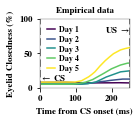

In [498]:
# Plot the empirical data
ts, days = load_avg_cr_plot_experimental_data()
fig = plot_cr_day_summary(ts, days, max_day=5, title='Empirical data')
fig.savefig('result-basic-closedness-ref.pdf', bbox_inches='tight', transparent=True)

In [513]:
data = [
    list(pytry.read('experiments_batch_1'))[0],
    list(pytry.read('experiments_batch_1'))[1],
    list(pytry.read('experiments_batch_1'))[2],
    list(pytry.read('experiments_batch_1'))[3],
    list(pytry.read('experiments_batch_1'))[4],
    list(pytry.read('experiments_batch_1'))[5],
]

#data = [
#    list(pytry.read('experiments_batch_2'))[0],
#    list(pytry.read('experiments_batch_2'))[0],
#    list(pytry.read('experiments_batch_2'))[0],
#    list(pytry.read('experiments_batch_2'))[0],
#    list(pytry.read('experiments_batch_2'))[0],
#    list(pytry.read('experiments_batch_2'))[0],
#]

#data = [
#    list(pytry.read('experiments_batch_3'))[0],
#    list(pytry.read('experiments_batch_3'))[1],
#    list(pytry.read('experiments_batch_3'))[2],
#    list(pytry.read('experiments_batch_3'))[3],
#    list(pytry.read('experiments_batch_3'))[4],
#    list(pytry.read('experiments_batch_3'))[5],
#]

data = [
    list(pytry.read('experiments_batch_4'))[0],
    list(pytry.read('experiments_batch_4'))[1],
    list(pytry.read('experiments_batch_4'))[2],
    list(pytry.read('experiments_batch_4'))[3],
    list(pytry.read('experiments_batch_4'))[4],
    list(pytry.read('experiments_batch_4'))[5],
]

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


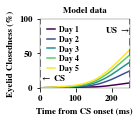

In [514]:
# Plot the model data
ts, days = compute_per_day_data(data)
fig = plot_cr_day_summary(ts, days, max_day=5, title="Model data")
fig.savefig('result-basic-closedness.pdf', bbox_inches='tight', transparent=True)

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


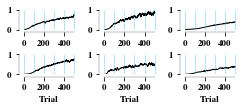

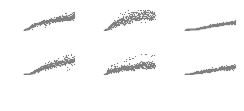

In [515]:
# Plot the model data
fig = plot_cr_for_each_trial(data, plot_dots=False)
fig.savefig('result-basic-atpuff.pdf', bbox_inches='tight', transparent=True)

fig = plot_cr_for_each_trial(data, plot_dots=True)
fig.savefig('result-basic-atpuff.png', bbox_inches='tight', transparent=True, dpi=600)

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


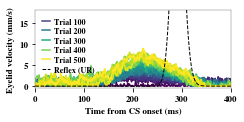

In [516]:
fig = plot_velocity(data[0])
fig.savefig('result-basic-velocity.pdf', bbox_inches='tight', transparent=True)